In [ ]:
from IPython.display import HTML, display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
import sys

def display_header(title, description, authors):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    author_list = "".join([f"<li style='font-size: 1.2em;'>{author}</li>" for author in authors])
    
    header_html = f"""
    <h1 style="font-size: 2.5em; font-weight: bold;">{title}</h1>
    <h2 style="font-size: 1.5em;">{description}</h2>

    <p style="font-size: 1.2em;"><strong>Authors:</strong></p>
    <ul style="list-style-type: none; padding: 0;">
    {author_list}
    </ul>
    <p style="font-size: 1.2em;"><strong>Date:</strong> {current_date}</p>
    """
    display(HTML(header_html))

def display_single_line(text):
    single_line_html = f"""
    <h1 style="font-size: 2em; font-weight: bold; text-align: left;">{title}</h1>
    """
    display(HTML(single_line_html))

def display_text(text):
    single_line_html = f"""
    <h1 style="font-size: 1.5em; font-weight: bold; text-align: left;">{title}</h1>
    """
    display(HTML(single_line_html))

title = "Accelerated Kinetic Monte Carlo Simulations of Atomistically-Resolved Resistive Memory Arrays - Artifact Evaluation"
description = "This notebook contains details on how to run small-scale versions of the experiments presented in the paper."
authors = ["Manasa Kaniselvan", "Alexander Maeder", "Marko Mladenović", "Mathieu Luisier", "Alexandros Nikolaos Ziogas"]
display_header(title, description, authors)

In [20]:
import chi
from chi import server
import os
import keystoneauth1, blazarclient
from chi import lease

title = "Environment setup:"
display_single_line(title)

chi.use_site("CHI@UC")

chi.set("project_name", "CHI-241321")

print(f'Using Project {chi.get("project_name")}')


# Load image (untested)
image = "CC-Ubuntu22.04-CUDA"
s = server.create_server(
    f"{os.getenv('USER')}-power-management", 
    image_name=image,
    reservation_id=lease.get_node_reservation(lease_id)
)
print("Waiting for server to start ...")
server.wait_for_active(s.id)
print("Done")


In [ ]:
floating_ip = lease.get_reserved_floating_ips(lease_id)[0]
server.associate_floating_ip(s.id, floating_ip_address=floating_ip)

print(f"Waiting for SSH connectivity on {floating_ip} ...")
timeout = 60*2
import socket
import time

# Repeatedly try to connect via SSH.
start_time = time.perf_counter()
while True:
    try:
        with socket.create_connection((floating_ip, 22), timeout=timeout):
            print("Connection successful")
            break
    except OSError as ex:
        time.sleep(10)
        if time.perf_counter() - start_time >= timeout:
            print(f"After {timeout} seconds, could not connect via SSH. Please try again.")

from chi import ssh

with ssh.Remote(floating_ip) as conn:
    # Upload the script
    conn.put("setup.sh")
    # Run the script
    conn.run("bash setup.sh")

In [ ]:
title = "Compile the code"
display_single_line(title)

# check gpu name
print("GPU Available:")
!nvidia-smi --query-gpu=gpu_name --format=csv
print("___________")

# compile code
!make

GPU Available:
name
Quadro P400
___________
MAKE INFO: Compiling with CUDA
MAKE INFO: Compile target - KMC Simulation ./bin/runKMC
make: Nothing to be done for `all'.


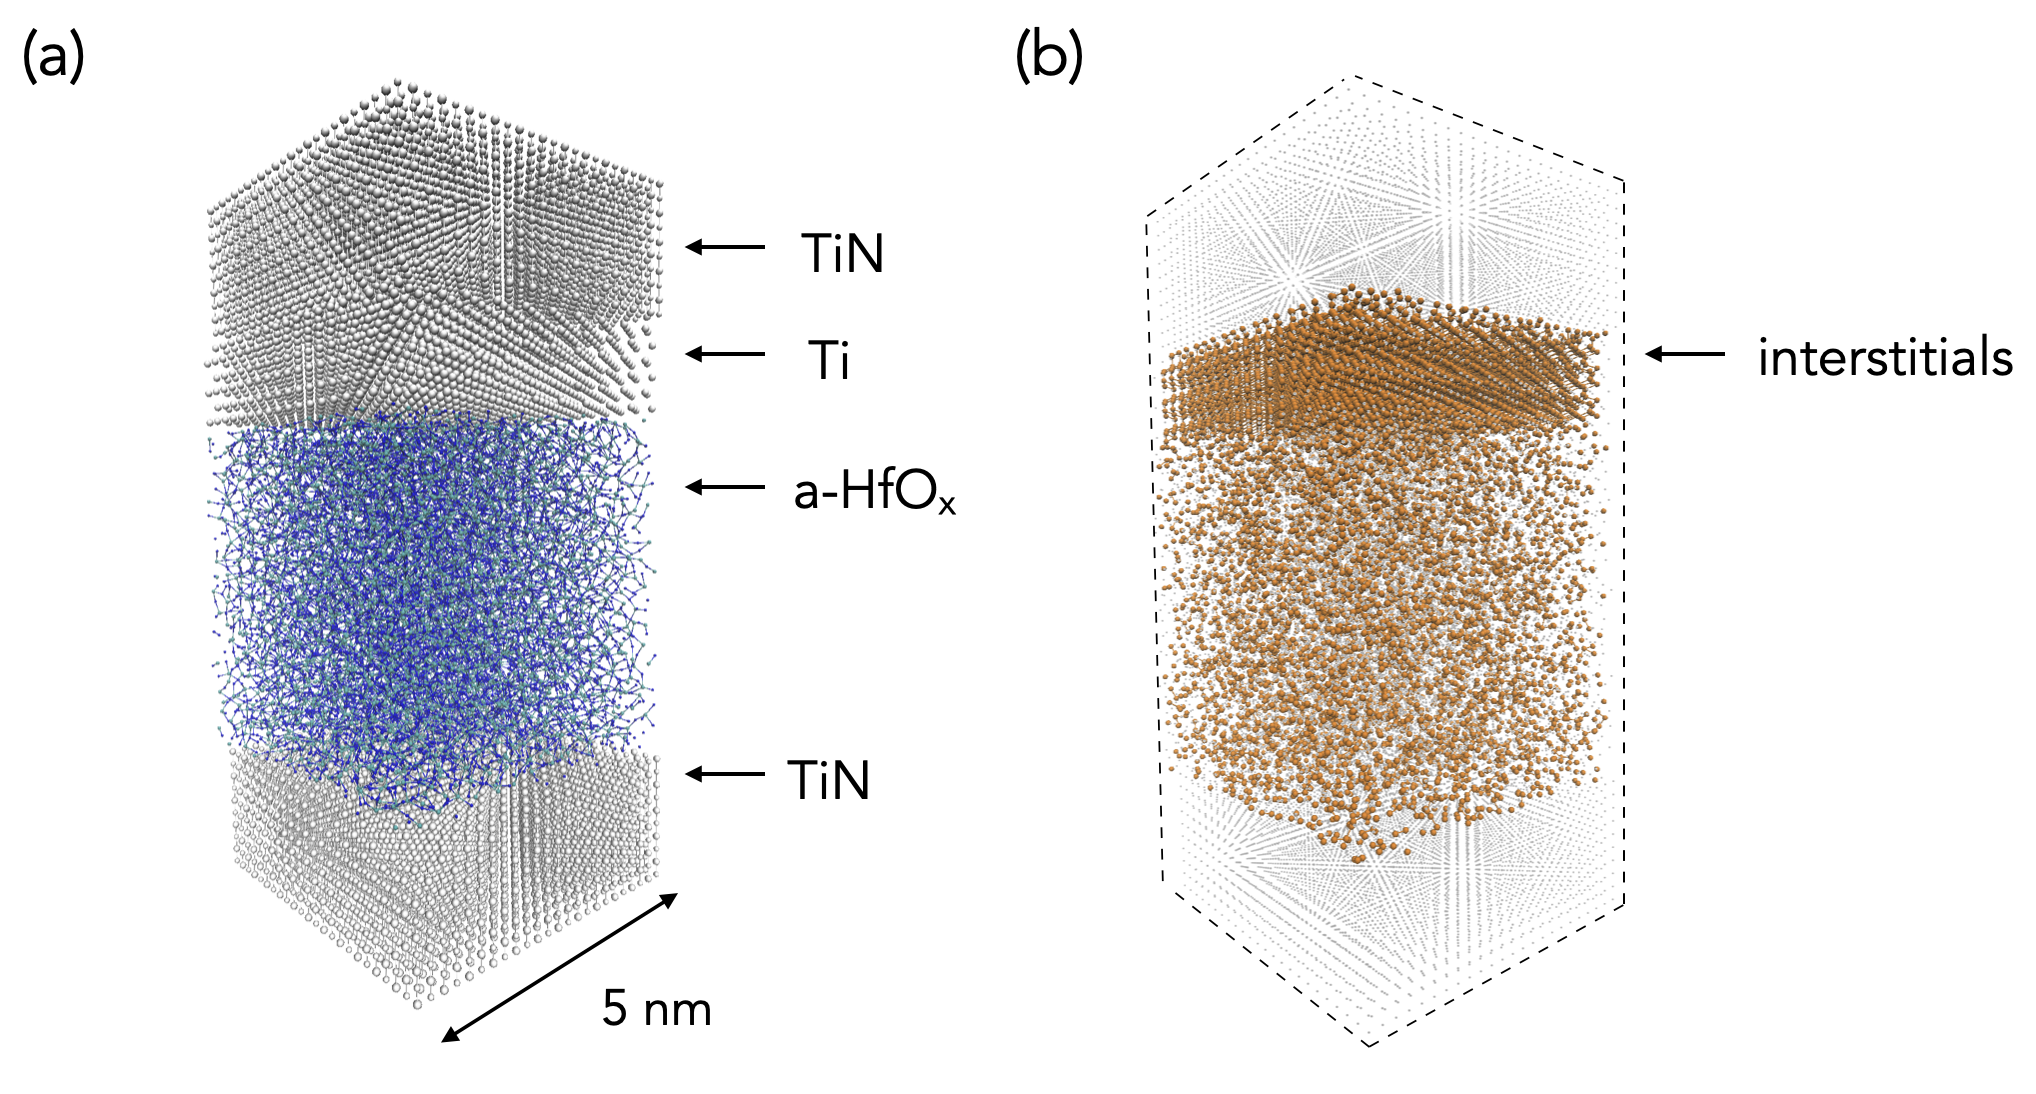

algonquin.ee.ethz.ch
bin/runKMC: Event not found.


In [ ]:
title = "Test 1 (Run) - Running a kinetic simulation on a toy structure (5 nm)"
display_single_line(title)

from IPython.display import Image
image = Image(filename='/usr/scratch/attelas8/manasa/arrayKMC/SC24-AE/figures/Fig2a-b.png', width=500)
display(image)

# print hostname
!hostname

# cd to the directory containing the toy structure and run the test with the input file:
!ssh attelas5; !cd SC24-AE/5nmx5nm_device; !bin/runKMC parameters.txt

Structure file snapshot_0.xyz found!
Structure file snapshot_6.xyz found!
Output file output1_0.txt found!
Structure: snapshot_0.xyz
Potential: [-2.5 -2.5 -2.5 ...  2.5  2.5  2.5]
Structure: snapshot_6.xyz
Potential: [-2.5 -2.5 -2.5 ...  2.5  2.5  2.5]


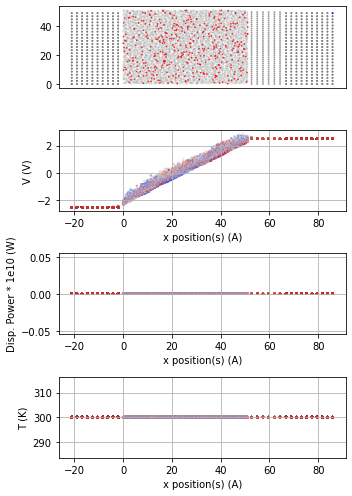

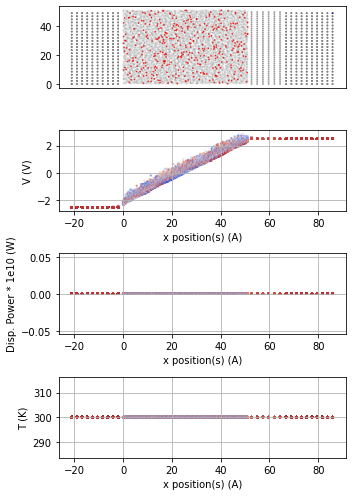

In [153]:
title = "Test 1 (Analyse) - Plot and visualize the results of the kinetic simulation"
display_single_line(title)

sys.path.append("./postprocessing")
from plot_device import read_xyz, make_image

output_file_loc = "SC24-AE/5nmx5nm_device/Results_5.000000/"
structure_filenames = ["snapshot_0.xyz", "snapshot_6.xyz"]
output_filename = "output1_0.txt"

# Error handling for missing files
try:
    for structure_filename in structure_filenames:
        with open(output_file_loc + structure_filename, "r") as f:
            print(f"Structure file {structure_filename} found!")
            pass
    with open(output_file_loc + "../" + output_filename, "r") as f:
        print(f"Output file {output_filename} found!")
        pass
except FileNotFoundError:
    print(f"Output file {output_filename} not found - something went wrong!")
    sys.exit(1)

for structure_filename in structure_filenames:
    folder = output_file_loc + structure_filename
    names, coords, potential, power, temperature = read_xyz(folder)
    print(f"Structure: {structure_filename}")
    print(f"Potential: {potential}")

    imname = structure_filename[0:-4]+'.jpg'
    make_image(names, coords, potential, power, temperature, output_file_loc, imname)

title = "Note: The visualizations in the manuscript were done with the VMD software, which is not available in this environment. However, we visualize here the locations of point defects in a 2D scatter plot."
display_text(text)

Structure file snapshot_0.xyz found!
Structure file snapshot_6.xyz found!
Output file output1_0.txt found!
Structure: snapshot_0.xyz
Potential: [-2.5 -2.5 -2.5 ...  2.5  2.5  2.5]
Structure: snapshot_6.xyz
Potential: [-2.5 -2.5 -2.5 ...  2.5  2.5  2.5]


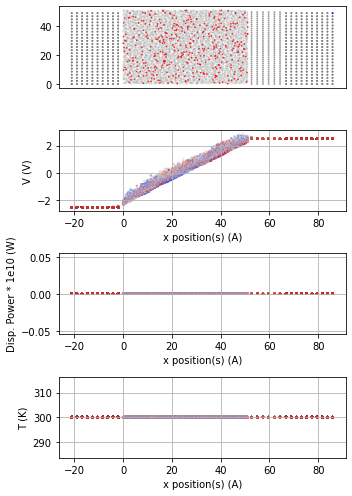

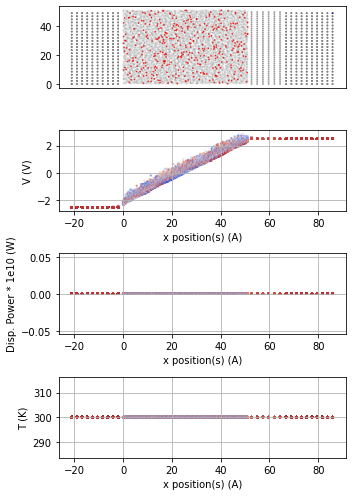

In [ ]:

output_file_locs = ["./SC24-AE/10nmx2nm_device_xsort/", "./SC24-AE/10nmx2nm_device_cuthillmckee/"]
output_filename = "output1_0.txt"

timing_data = {
    "KMC step count": [],
    "Z - calculation time - charge [s]": [],
    "Z - calculation time - dissipated power [s]": [],
    "Z - calculation time - potential from boundaries [s]": [],
    "Z - calculation time - potential from charges [s]": [],
    "Z - calculation time - kmc events [s]": [],
    "Z - calculation time - KMC superstep [s]": [],
}

boundary_potential_mean = []
boundary_potential_std = []

for output_file_loc in output_file_locs:
    
    filename = output_file_loc + output_filename   
    with open(filename, "r") as file:
        lines = file.readlines()
        current_kmc_step = None

        for line in lines:
            if "KMC step count" in line:
                current_kmc_step = int(line.split(":")[-1].strip())
            elif "Z - calculation time" in line:
                key, value = map(str.strip, re.split(r':\s+', line, maxsplit=1))
                if key in timing_data:
                    timing_data[key].append(float(value))
                    timing_data["KMC step count"].append(current_kmc_step)

    superstep_measurements = timing_data["Z - calculation time - potential from boundaries [s]"]
        
    # add to second dimension of boundary_potential_data
    boundary_potential_mean.append(np.mean(superstep_measurements))
    boundary_potential_std.append(np.std(superstep_measurements))

# boxplot of the boundary_potential_data 
labels = ["10nmx2nm_device_xsort", "10nmx2nm_device_cuthillmckee"]
plot = plt.errorbar(labels, boundary_potential_mean, yerr=boundary_potential_std, fmt='o')

text2 = "Expected results: The boundary potential calculation time should be lower for the the Cuthill-McKee ordering compared to the x-sort."
display_text(text2)